# Practical Deep Learning for Coders, v3

# Lesson3_imdb

# IMDB影评数据

In [ ]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [ ]:
from fastai.text import *

## Preparing the data 准备数据

First let's download the dataset we are going to study. The [dataset](http://ai.stanford.edu/~amaas/data/sentiment/) has been curated by Andrew Maas et al. and contains a total of 100,000 reviews on IMDB. 25,000 of them are labelled as positive and negative for training, another 25,000 are labelled for testing (in both cases they are highly polarized). The remaning 50,000 is an additional unlabelled data (but we will find a use for it nonetheless).

首先，让我们先下载需要使用的数据。 [IMDB](http://ai.stanford.edu/~amaas/data/sentiment/) 数据集由Andrew Maas等人收集，里面有10万条IMDB网站上的影评。其中2.5万条是积极的评论, 2.5万条是消极的评论, 另外2.5万条是用作测试的评论(这些数据两极分化得很厉害)，剩余的5万条是额外的未标记的数据（以后我们会将这些数据用做其他用途）。

We'll begin with a sample we've prepared for you, so that things run quickly before going over the full dataset.

我们一起来看一下提前准备好的样本，这样会比跑遍整个数据集快一些。

In [ ]:
path = untar_data(URLs.IMDB_SAMPLE)
path.ls()

[PosixPath('/home/ubuntu/notebooks/data/imdb_sample/data_clas_export.pkl'),
 PosixPath('/home/ubuntu/notebooks/data/imdb_sample/export_lm.pkl'),
 PosixPath('/home/ubuntu/notebooks/data/imdb_sample/export.pkl'),
 PosixPath('/home/ubuntu/notebooks/data/imdb_sample/texts.csv'),
 PosixPath('/home/ubuntu/notebooks/data/imdb_sample/data_lm_export.pkl'),
 PosixPath('/home/ubuntu/notebooks/data/imdb_sample/export_clas.pkl'),
 PosixPath('/home/ubuntu/notebooks/data/imdb_sample/models'),
 PosixPath('/home/ubuntu/notebooks/data/imdb_sample/save_data_clas.pkl')]

It only contains one csv file, let's have a look at it.

例子里只包含了一个csv文档，我们一起来看一下里面的数据。

In [ ]:
df = pd.read_csv(path/'texts.csv')
df.head()

label                                               text  is_valid
0  negative  Un-bleeping-believable! Meg Ryan doesn't even ...     False
1  positive  This is a extremely well-made film. The acting...     False
2  negative  Every once in a long while a movie will come a...     False
3  positive  Name just says it all. I watched this movie wi...     False
4  negative  This movie succeeds at being one of the most u...     False

In [ ]:
df['text'][1]

'This is a extremely well-made film. The acting, script and camera-work are all first-rate. The music is good, too, though it is mostly early in the film, when things are still relatively cheery. There are no really superstars in the cast, though several faces will be familiar. The entire cast does an excellent job with the script.<br /><br />But it is hard to watch, because there is no good end to a situation like the one presented. It is now fashionable to blame the British for setting Hindus and Muslims against each other, and then cruelly separating them into two countries. There is some merit in this view, but it\'s also true that no one forced Hindus and Muslims in the region to mistreat each other as they did around the time of partition. It seems more likely that the British simply saw the tensions between the religions and were clever enough to exploit them to their own ends.<br /><br />The result is that there is much cruelty and inhumanity in the situation and this is very u

It contains one line per review, with the label ('negative' or 'positive'), the text and a flag to determine if it should be part of the validation set or the training set. If we ignore this flag, we can create a DataBunch containing this data in one line of code:

文档里的每一行都是一个影评，影评附有标签（“负面”或是“正面”）、评论文字以及一个标明是属于训练集还是验证集的标签，如果我们忽略这个（标明所属数据集的）标签，我们可以有下面这行代码来产生一个 DataBunch（数据堆）：

In [ ]:
data_lm = TextDataBunch.from_csv(path, 'texts.csv')

By executing this line a process was launched that took a bit of time. Let's dig a bit into it. Images could be fed (almost) directly into a model because they're just a big array of pixel values that are floats between 0 and 1. A text is composed of words, and we can't apply mathematical functions to them directly. We first have to convert them to numbers. This is done in two differents steps: tokenization and numericalization. A `TextDataBunch` does all of that behind the scenes for you.

运行这行代码会启动一个需要稍微花点时间的程序，让我们来更深入地了解一下。图像本质上是一个巨大的像素值数列，这个数列由0到1 之间的数字组成，因此图像数据基本上可以直接输入到模型中。但是，一段文字是由词组成的，而我们不能直接对词运用数学函数。那么我们首先需要将这些信息转化为数字。这一过程需要通过两部完成：分词和数值化。`TextDataBunch`在幕后为您完成所有这些工作。

Before we delve into the explanations, let's take the time to save the things that were calculated.

在我们开始讲解内容之前，让我们先花点时间将计算好的数据存档。


In [ ]:
data_lm.save()

Next time we launch this notebook, we can skip the cell above that took a bit of time (and that will take a lot more when you get to the full dataset) and load those results like this:

下次我们启动这个notebook, 可以直接跳过之前稍费时间的单元格，直接用下面的代码载入之前保存的结果（如果你载入的是全部数据，之前这些步骤会花费更多时间）：

In [ ]:
data = load_data(path)

### Tokenization 分词

The first step of processing we make the texts go through is to split the raw sentences into words, or more exactly tokens. The easiest way to do this would be to split the string on spaces, but we can be smarter:

处理数据的第一步是将文字分拆成单词, 或者更确切地说, 标准词(tokens)。最简单的方式是基于空格对句子进行分拆, 但我们能更智能地分词：

- we need to take care of punctuation
<br>我们需要考虑标点

- some words are contractions of two different words, like isn't or don't
<br>有些词是由两个不同的词缩写的，比如isn't或don't

- we may need to clean some parts of our texts, if there's HTML code for instance
<br>我们可能需要清理文本的某些部分，比如文字中可能会有HTML代码

To see what the tokenizer had done behind the scenes, let's have a look at a few texts in a batch.<br>
为了明白分词器幕后是如何工作的，让我们来看一下数据堆中的一些文本。

In [ ]:
data = TextClasDataBunch.from_csv(path, 'texts.csv')
data.show_batch()

The texts are truncated at 100 tokens for more readability. We can see that it did more than just split on space and punctuation symbols: 

为了更简洁易读，我们将所有评论删节到100个词。我们可以看到文字标记化算法不仅仅是基于空格和标点进行了分词：

- the "'s" are grouped together in one token
<br>所有“'s”都被合并为一个标准词


- the contractions are separated like this: "did", "n't"
<br>词语的缩写被分开，比如“did” 和 “n't”


- content has been cleaned for any HTML symbol and lower cased
<br>所有包含HTML连接的内容被清理，并且所有文字都采用小写


- there are several special tokens (all those that begin by xx), to replace unknown tokens (see below) or to introduce different text fields (here we only have one).
<br>为了代替未知的标准词（如下）或者引入不同的文本字段(这里我们只有一个)，（在结果中可以看到）有一些特殊的标准词（它们都以xx开头）

### Numericalization 数值化

Once we have extracted tokens from our texts, we convert to integers by creating a list of all the words used. We only keep the ones that appear at least twice with a maximum vocabulary size of 60,000 (by default) and replace the ones that don't make the cut by the unknown token `UNK`.

一旦我们从文本中完成了标准词提取，就会生成一个包含所有词汇的列表，将标准词转化成整数。这里我们只保留至少出现两次的标准词，并设置词库上限为60,000(默认设置), 同时将所有不能分进行分词的词标记为“未知标准词” `UNK`。

The correspondance from ids to tokens is stored in the `vocab` attribute of our datasets, in a dictionary called `itos` (for int to string).

id和标准词的关系存储在数据集的`vocab`属性中，在字典 `itos` 中（由int类型转换成string类型）。

In [ ]:
data.vocab.itos[:10]

['xxunk',
 'xxpad',
 'xxbos',
 'xxfld',
 'xxmaj',
 'xxup',
 'xxrep',
 'xxwrep',
 'the',
 '.']

And if we look at what a what's in our datasets, we'll see the tokenized text as a representation:

如果我们查看数据集里的“what's”的形式，我们会看到如下经过分词后的文本： 

In [ ]:
data.train_ds[0][0]

Text xxbos i know that originally , this film was xxup not a box office hit , but in light of recent xxmaj hollywood releases ( most of which have been decidedly formula - ridden , plot less , pointless , " save - the - blonde - chick - no - matter - what " xxunk ) , xxmaj xxunk of xxmaj all xxmaj xxunk , certainly in this sorry context deserves a second opinion . xxmaj the film -- like the book -- loses xxunk in some of the historical background , but it xxunk a uniquely xxmaj american dilemma set against the uniquely horrific xxmaj american xxunk of human xxunk , and some of its tragic ( and funny , and touching ) consequences . 

 xxmaj and worthy of xxunk out is the youthful xxmaj robert xxmaj xxunk , cast as the leading figure , xxmaj xxunk , whose xxunk xxunk is truly universal as he sets out in the beginning of his ' coming of age , ' only to be xxunk disappointed at what turns out to become his true education in the ways of the xxmaj southern plantation world of xxmaj xxunk , a

But the underlying data is all numbers

但实际上，底层的数据形式都是数字

In [ ]:
data.train_ds[0][0].data[:10]

array([   2,   18,  146,   19, 3788,   10,   20,   31,   25,    5])

### With the data block API 用data block API处理文字

We can use the data block API with NLP and have a lot more flexibility than what the default factory methods offer. In the previous example for instance, the data was randomly split between train and validation instead of reading the third column of the csv.

活地处理各种情况。比如在之前的例子中，数据随机分为训练集和验证集，而非通过读取csv中第三列的标签来分组。

With the data block API though, we have to manually call the tokenize and numericalize steps. This allows more flexibility, and if you're not using the defaults from fastai, the various arguments to pass will appear in the step they're revelant, so it'll be more readable.

不过如果要使用数据块API，我们需要手动完成分词和数值化的各个步骤。这样可以更加灵活。如果你没有使用fastai工具包里的默认设置，你也可以像下面的步骤一样进行各种设置，并且代码可读性也更高。

In [ ]:
data = (TextList.from_csv(path, 'texts.csv', cols='text')
                .split_from_df(col=2)
                .label_from_df(cols=0)
                .databunch())

## Language model 语言模型

Note that language models can use a lot of GPU, so you may need to decrease batchsize here.

需要注意的是语言文字模型会用掉许多GPU，因此你可能会需要减小每个批次的样本容量。

In [ ]:
bs=48

Now let's grab the full dataset for what follows.

现在我们为接下来的步骤获取完整的数据集。

In [ ]:
path = untar_data(URLs.IMDB)
path.ls()

[PosixPath('/home/ubuntu/.fastai/data/imdb/test'),
 PosixPath('/home/ubuntu/.fastai/data/imdb/tmp_clas'),
 PosixPath('/home/ubuntu/.fastai/data/imdb/README'),
 PosixPath('/home/ubuntu/.fastai/data/imdb/unsup'),
 PosixPath('/home/ubuntu/.fastai/data/imdb/train'),
 PosixPath('/home/ubuntu/.fastai/data/imdb/tmp_lm'),
 PosixPath('/home/ubuntu/.fastai/data/imdb/models'),
 PosixPath('/home/ubuntu/.fastai/data/imdb/imdb.vocab')]

In [ ]:
(path/'train').ls()

[PosixPath('/home/ubuntu/.fastai/data/imdb/train/neg'),
 PosixPath('/home/ubuntu/.fastai/data/imdb/train/unsupBow.feat'),
 PosixPath('/home/ubuntu/.fastai/data/imdb/train/pos'),
 PosixPath('/home/ubuntu/.fastai/data/imdb/train/labeledBow.feat')]

The reviews are in a training and test set following an imagenet structure. The only difference is that there is an `unsup` folder on top of `train` and `test` that contains the unlabelled data.

现在影评遵循imagenet的结构分到了训练集和测试集中。唯一的区别是，在`测试集`和`训练集`上会有个包括未标记数据的`unsup`文件夹。

We're not going to train a model that classifies the reviews from scratch. Like in computer vision, we'll use a model pretrained on a bigger dataset (a cleaned subset of wikipedia called [wikitext-103](https://einstein.ai/research/blog/the-wikitext-long-term-dependency-language-modeling-dataset)). That model has been trained to guess what the next word is, its input being all the previous words. It has a recurrent structure and a hidden state that is updated each time it sees a new word. This hidden state thus contains information about the sentence up to that point.

我们不需要从无到有地训练一个影评分类模型。就像计算机视觉模型一样，我们将使用一个在更大训练集上预训练好的模型（在维基上有一个清洗好的子集  [wikitext-103](https://einstein.ai/research/blog/the-wikitext-long-term-dependency-language-modeling-dataset) ）。这个模型被训练来猜测下一个词是什么，它的输入数据是之前已有的词汇。该模型采用循环神经网络结构，并且有一个每次看到新词都会更新的隐层状态。 隐层状态里包含的信息，是文本中到截止这个点之前的所有句子。

We are going to use that 'knowledge' of the English language to build our classifier, but first, like for computer vision, we need to fine-tune the pretrained model to our particular dataset. Because the English of the reviews left by people on IMDB isn't the same as the English of wikipedia, we'll need to adjust the parameters of our model by a little bit. Plus there might be some words that would be extremely common in the reviews dataset but would be barely present in wikipedia, and therefore might not be part of the vocabulary the model was trained on.

我们用这样的预训练模型信息来创建我们的分类器。但首先，正如计算机视觉一样，我们需要对预训练的模型进行调参来适应我们的这个数据集。由于IMDB上影评的英语语言和维基百科上的英语语言风格不尽相同，我们需要将参数进行一定的调整。另外，可能会有些词在影评数据中出现的频率较高，但在维基百科上基本没出现过，因此可能和模型预训练时用的词库不太一样。

This is where the unlabelled data is going to be useful to us, as we can use it to fine-tune our model. Let's create our data object with the data block API (next line takes a few minutes).

我们可以用未标记的数据进行模型微调，这就是未标记数据具有价值的地方。让我们通过数据块API来建立一个数据对象。（下行会花费数分钟的时间）

In [ ]:
data_lm = (TextList.from_folder(path)
           #Inputs: all the text files in path
            .filter_by_folder(include=['train', 'test', 'unsup']) 
           #We may have other temp folders that contain text files so we only keep what's in train and test
            .split_by_rand_pct(0.1)
           #We randomly split and keep 10% (10,000 reviews) for validation
            .label_for_lm()           
           #We want to do a language model so we label accordingly
            .databunch(bs=bs))
data_lm.save('data_lm.pkl')

We have to use a special kind of `TextDataBunch` for the language model, that ignores the labels (that's why we put 0 everywhere), will shuffle the texts at each epoch before concatenating them all together (only for training, we don't shuffle for the validation set) and will send batches that read that text in order with targets that are the next word in the sentence.

对于语言模型，我们需要用一个特殊的`TextDataBunch`，它会忽略标签（这就是为什么我们给所有地方都设置为0的原因），在将每个轮次的文字合并在一起之前打乱所有的文字（仅限于模型训练，我们不会对验证集进行混洗），并会分批次按顺序读取文字和接下来对应的单词。

The line before being a bit long, we want to load quickly the final ids by using the following cell.

之前的代码会有点长，我们可以用下面的代码用id快速导入对应的文字。

In [ ]:
data_lm = load_data(path, 'data_lm.pkl', bs=bs)

In [ ]:
data_lm.show_batch()

We can then put this in a learner object very easily with a model loaded with the pretrained weights. They'll be downloaded the first time you'll execute the following line and stored in `~/.fastai/models/` (or elsewhere if you specified different paths in your config file).

我们可以很轻易地将模型和预训练的权重结合为一个学习器对象。在你第一次运行下面的代码时，所有模型的信息会下载并存储到`~/.fastai/models/` 或者其他由你的config文件指定的地方。

In [ ]:
learn = language_model_learner(data_lm, AWD_LSTM, drop_mult=0.3)

In [ ]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


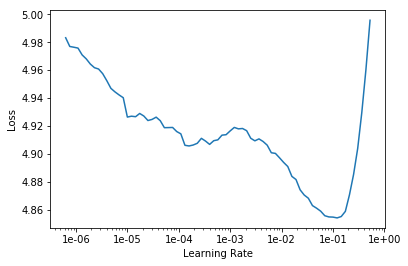

In [ ]:
learn.recorder.plot(skip_end=15)

In [ ]:
learn.fit_one_cycle(1, 1e-2, moms=(0.8,0.7))

In [ ]:
learn.save('fit_head')

In [ ]:
learn.load('fit_head');

To complete the fine-tuning, we can then unfeeze and launch a new training.

要完成微调，我们可以解冻模型并开启新的训练。

In [ ]:
learn.unfreeze()

In [ ]:
learn.fit_one_cycle(10, 1e-3, moms=(0.8,0.7))

In [ ]:
learn.save('fine_tuned')

How good is our model? Well let's try to see what it predicts after a few given words.

我们的模型表现怎么样呢？ 嗯，让我们来看看在几个词过后模型预测出的词是怎样的。

In [ ]:
learn.load('fine_tuned');

In [ ]:
TEXT = "I liked this movie because"
N_WORDS = 40
N_SENTENCES = 2

In [ ]:
print("\n".join(learn.predict(TEXT, N_WORDS, temperature=0.75) for _ in range(N_SENTENCES)))

I liked this movie because of the cool scenery and the high level of xxmaj british hunting . xxmaj the only thing this movie has going for it is the horrible acting and no script . xxmaj the movie was a big disappointment . xxmaj
I liked this movie because it was one of the few movies that made me laugh so hard i did n't like it . xxmaj it was a hilarious film and it was very entertaining . 

 xxmaj the acting was great , i 'm


We have to save not only the model, but also its encoder, the part that's responsible for creating and updating the hidden state. For the next part, we don't care about the part that tries to guess the next word.

我们不但保存了模型，而且保存了它的编码器，（也就是）负责创建和更新隐层状态（的部分）。剩下的负责猜词的部分，我们就不管了。



In [ ]:
learn.save_encoder('fine_tuned_enc')

## Classifier 分类器

Now, we'll create a new data object that only grabs the labelled data and keeps those labels. Again, this line takes a bit of time.

现在我们要创建一个新的数据对象，仅抓取有标签的数据并且保留标签。这个步骤可能会需要一点时间。

In [ ]:
path = untar_data(URLs.IMDB)

In [ ]:
data_clas = (TextList.from_folder(path, vocab=data_lm.vocab)
             #grab all the text files in path
             .split_by_folder(valid='test')
             #split by train and valid folder (that only keeps 'train' and 'test' so no need to filter)
             .label_from_folder(classes=['neg', 'pos'])
             #label them all with their folders
             .databunch(bs=bs))

data_clas.save('data_clas.pkl')

In [ ]:
data_clas = load_data(path, 'data_clas.pkl', bs=bs)

In [ ]:
data_clas.show_batch()

We can then create a model to classify those reviews and load the encoder we saved before.

我们可以建立一个模型来对影评进行分类，并且导入之前存储好的编码器。

In [ ]:
learn = text_classifier_learner(data_clas, AWD_LSTM, drop_mult=0.5)
learn.load_encoder('fine_tuned_enc')

In [ ]:
learn.lr_find()

In [ ]:
learn.recorder.plot()

In [ ]:
learn.fit_one_cycle(1, 2e-2, moms=(0.8,0.7))

In [ ]:
learn.save('first')

In [ ]:
learn.load('first');

In [ ]:
learn.freeze_to(-2)
learn.fit_one_cycle(1, slice(1e-2/(2.6**4),1e-2), moms=(0.8,0.7))

In [ ]:
learn.save('second')

In [ ]:
learn.load('second');

In [ ]:
learn.freeze_to(-3)
learn.fit_one_cycle(1, slice(5e-3/(2.6**4),5e-3), moms=(0.8,0.7))

In [ ]:
learn.save('third')

In [ ]:
learn.load('third');

In [ ]:
learn.unfreeze()
learn.fit_one_cycle(2, slice(1e-3/(2.6**4),1e-3), moms=(0.8,0.7))

In [ ]:
learn.predict("I really loved that movie, it was awesome!")

(Category pos, tensor(1), tensor([7.5928e-04, 9.9924e-01]))